In [1]:
import os

import numpy as np
import pandas as pd
import polars as pl

In [2]:
cwd = os.getcwd()
cwd, _ = os.path.split(cwd)
cwd

'/Users/fynn/Uni/MA'

In [3]:
import tensorflow as tf
from tensorflow import keras

BATCH_SIZE = 100_000
samples = os.path.join(cwd, "data", "train", "2D", "MIP")

train_dataset = keras.preprocessing.text_dataset_from_directory(
    directory = samples,
    labels = None,
    batch_size = BATCH_SIZE,
    max_length = None,
    shuffle = True,
    seed = 3093453,
    follow_links = False
)

Found 489623 files belonging to 1 classes.


2023-12-24 11:28:39.708401: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-12-24 11:28:39.708435: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-12-24 11:28:39.708439: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-12-24 11:28:39.708490: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-24 11:28:39.708507: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
for X in train_dataset.take(1):
    pass

2023-12-24 11:28:49.847600: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 324382 of 800000
2023-12-24 11:28:55.999469: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


In [5]:
y = pd.Series(X.numpy().astype(str)).str.extractall("MIP Improvement( )")
y = y.groupby(y.index.get_level_values(0)).count().to_numpy()[:,0]
y = (y == 1)

In [6]:
print(X.numpy().astype(str)[0])

dataset: B
instance: SA
+-----------+
2D Packing MIP with Time Limit 20.682024516261794 [s] in Truck P319157701
Stack 0 with items: ['0090017100_26102022015069']
Stack 1 with items: ['0090017100_26102022013534']
Stack 2 with items: ['0090017100_26102022012241', '0090017100_26102022006460']
Stack 3 with items: ['0090017100_26102022008592']
Stack 4 with items: ['0090017100_26102022006460', '0090017100_26102022006460']
Stack 5 with items: ['0090017100_26102022004063', '0090017100_26102022003619']
Stack 6 with items: ['0090017100_26102022003777']
Stack 7 with items: ['0090017100_26102022003777']
Stack 8 with items: ['0090017100_26102022003777']
Stack 9 with items: ['0090017100_26102022003619', '0090017100_26102022003619']
Stack 10 with items: ['0090017100_26102022003619', '0090017100_26102022003230']
Stack 11 with items: ['0090017100_26102022003306']
Stack 12 with items: ['0090017100_26102022003230', '0090017100_26102022003230']
Stack 13 with items: ['0090017100_26102022003077', '009001710

In [7]:
X = X.numpy().astype(str)
df = pl.DataFrame({"raw": X})
print(df[0, 0])

dataset: B
instance: SA
+-----------+
2D Packing MIP with Time Limit 20.682024516261794 [s] in Truck P319157701
Stack 0 with items: ['0090017100_26102022015069']
Stack 1 with items: ['0090017100_26102022013534']
Stack 2 with items: ['0090017100_26102022012241', '0090017100_26102022006460']
Stack 3 with items: ['0090017100_26102022008592']
Stack 4 with items: ['0090017100_26102022006460', '0090017100_26102022006460']
Stack 5 with items: ['0090017100_26102022004063', '0090017100_26102022003619']
Stack 6 with items: ['0090017100_26102022003777']
Stack 7 with items: ['0090017100_26102022003777']
Stack 8 with items: ['0090017100_26102022003777']
Stack 9 with items: ['0090017100_26102022003619', '0090017100_26102022003619']
Stack 10 with items: ['0090017100_26102022003619', '0090017100_26102022003230']
Stack 11 with items: ['0090017100_26102022003306']
Stack 12 with items: ['0090017100_26102022003230', '0090017100_26102022003230']
Stack 13 with items: ['0090017100_26102022003077', '009001710

# Processing functions:

## Extract raw data

In [8]:
def extract_raw_data(df: pl.DataFrame) -> pl.DataFrame:
    """
    Extracts features via regex from raw txt-file input.
    Drops rows which dont contain a truck_id or 3D packing instances
    """
    df = df.with_columns([
        pl.Series(name="index", values=np.arange(len(df.collect()))),
        #pl.Series(name="index", values=np.arange(len(df))),
        pl.col("raw").str.extract("in Truck (\w\d{9})\n").alias("truck_id"),
        pl.col("raw").str.extract("dataset: (\w*)\n").alias("dataset"),
        pl.col("raw").str.extract("instance: ([A-Z0-9]*)\n").alias("instance"),
    ])
    
    return df


In [9]:
(
    df.lazy()
    .pipe(extract_raw_data)
    .collect()
    .head()
)

raw,index,truck_id,dataset,instance
str,i64,str,str,str
"""dataset: B ins…",0,"""P319157701""","""B""","""SA"""
"""dataset: C ins…",1,"""P086011101""","""C""","""CL3"""
"""dataset: C ins…",2,"""P069355303""","""C""","""BY"""
"""dataset: C ins…",3,"""P082010011""","""C""","""CL3"""
"""dataset: C ins…",4,"""P081060621""","""C""","""BY3"""


## Explode instance into stacks:

In [10]:
def explode_instances_into_stacks(df: pl.LazyFrame) -> pl.DataFrame:
    """
    Use regex to extract all stacks made of item ids, and explode df
    into rows of stacks, belonging to an instance.
    """
    
    df = (
        df.with_columns([
            pl.col("raw").str.extract_all("Stack \d* with items: (\[.*\])\n").alias("stacks")
        ])
          .drop(["raw"])
          .explode(columns = ["stacks"])\
          .with_columns([
              pl.col("stacks").str.extract("Stack (\d*) with").cast(pl.Int64, strict=False).alias("stack_id"),
              pl.col("stacks").str.extract_all("(\d{10}_\d{14})").alias("item_id")
          ])
    )
    return df


In [11]:
(
    df.lazy()
    .pipe(extract_raw_data)
    .pipe(explode_instances_into_stacks)
    .collect()
    .head()
)

index,truck_id,dataset,instance,stacks,stack_id,item_id
i64,str,str,str,str,i64,list[str]
0,"""P319157701""","""B""","""SA""","""Stack 0 with i…",0,"[""0090017100_26102022015069""]"
0,"""P319157701""","""B""","""SA""","""Stack 1 with i…",1,"[""0090017100_26102022013534""]"
0,"""P319157701""","""B""","""SA""","""Stack 2 with i…",2,"[""0090017100_26102022012241"", ""0090017100_26102022006460""]"
0,"""P319157701""","""B""","""SA""","""Stack 3 with i…",3,"[""0090017100_26102022008592""]"
0,"""P319157701""","""B""","""SA""","""Stack 4 with i…",4,"[""0090017100_26102022006460"", ""0090017100_26102022006460""]"


## Explode stacks into items:

In [12]:
def explode_stacks_into_items(df: pl.DataFrame) -> pl.DataFrame:
    """
    Use regex to identify a stack and explode it into items,
    belonging to a stack, which again belongs to an instance.
    """
    df = df.with_columns([
        pl.col("stacks").str.extract("Stack (\d*) with").cast(pl.Int64, strict=False).alias("stack_id"),
        pl.col("stacks").str.extract_all("(\d{10}_\d{14})").alias("item_id")
    ]).drop("stacks").explode("item_id")\
    
    return df

In [13]:
(
    df.lazy()
    .pipe(extract_raw_data)
    .pipe(explode_instances_into_stacks)
    .pipe(explode_stacks_into_items)
    .collect()
    #.head()
)

index,truck_id,dataset,instance,stack_id,item_id
i64,str,str,str,i64,str
0,"""P319157701""","""B""","""SA""",0,"""0090017100_261…"
0,"""P319157701""","""B""","""SA""",1,"""0090017100_261…"
0,"""P319157701""","""B""","""SA""",2,"""0090017100_261…"
0,"""P319157701""","""B""","""SA""",2,"""0090017100_261…"
0,"""P319157701""","""B""","""SA""",3,"""0090017100_261…"
0,"""P319157701""","""B""","""SA""",4,"""0090017100_261…"
0,"""P319157701""","""B""","""SA""",4,"""0090017100_261…"
0,"""P319157701""","""B""","""SA""",5,"""0090017100_261…"
0,"""P319157701""","""B""","""SA""",5,"""0090017100_261…"


## Load and Merge Items

In [14]:
folder = "truck-item-infos"
file = "items.csv"

item_path = os.path.join(cwd, folder, file)
items = pl.read_csv(source = item_path);

items = items.lazy().with_columns([
    (pl.col("Item ident").alias("item_id")),
    (pl.col("Length") / 1000), # mm to m
    (pl.col("Width") / 1000),  # mm to m
    (pl.col("Height") / 1000), # mm to m
    (pl.col("Nesting height") / 1000), # mm to m
    (pl.col("Weight") / 1000), # kg to tons
    (pl.col("Forced orientation") == "lengthwise").alias("ForcedLength"),
    (pl.col("Forced orientation") == "widthwise").alias("ForcedWidth"),
    ((pl.col("Height") - pl.col("Nesting height")) / 1000).alias("NestedHeight"),
    pl.col("dataset").str.extract("([A-Z])")
]).drop([
    "Forced orientation", "Max stackability", "Inventory cost",
    "Earliest arrival time", "Latest arrival time", "Number of items",
    "instance_id",
    "Stackability code",
    "Item ident" # drop because of rename earlier
]).unique()

items.collect().head()

Supplier code,Supplier dock,Plant code,Plant dock,Product code,Package code,Length,Width,Height,Weight,Nesting height,dataset,instance,item_id,ForcedLength,ForcedWidth,NestedHeight
i64,str,i64,str,str,str,f64,f64,f64,f64,f64,str,str,str,bool,bool,f64
11740101,null,90016900,"""169GD-60""","""140461084R""","""SLI---0770""",1.2,1.0,0.975,0.172384,0.045,"""C""","""BY""","""0090016900_270…",false,false,0.93
24979000,null,90016900,"""169GB-20""","""651125403R""","""MTEM--7890""",2.4,2.2,1.35,0.4911,0.045,"""C""","""BY""","""0090016900_270…",false,false,1.305
2573222,null,90016900,"""169GB-10""","""766396151R""","""SLI---2000""",2.4,1.2,0.975,0.5626,0.045,"""C""","""BY""","""0090016900_270…",false,false,0.93
27376000,null,90016900,"""GRD1""","""552066541R""","""SLI---0601""",1.2,1.0,0.75,0.32068,0.045,"""C""","""BY""","""0090016900_270…",false,false,0.705
3043102,null,90016900,"""169GD-60""","""679403988R""","""SLI---0760""",1.2,1.0,0.93,0.123752,0.045,"""C""","""BY""","""0090016900_270…",false,false,0.885


In [15]:
def join_items(df: pl.DataFrame, items) -> pl.DataFrame:
    """
    Perform a simple left join to add item level info.
    
    Validation sadly not supported for multiple keys (yet?)
    """
    
    return df.join(items, how = "left", on = ["dataset", "instance", "item_id"])

In [16]:
(
    df.lazy()
    .pipe(extract_raw_data)
    .pipe(explode_instances_into_stacks)
    .pipe(explode_stacks_into_items)
    .pipe(join_items, items)
    .collect()
    .head()
)

index,truck_id,dataset,instance,stack_id,item_id,Supplier code,Supplier dock,Plant code,Plant dock,Product code,Package code,Length,Width,Height,Weight,Nesting height,ForcedLength,ForcedWidth,NestedHeight
i64,str,str,str,i64,str,i64,str,i64,str,str,str,f64,f64,f64,f64,f64,bool,bool,f64
0,"""P319157701""","""B""","""SA""",0,"""0090017100_261…",201500,null,90017100,"""171C12""","""739105254R""","""ECM---6841""",1.8,1.2,2.95,0.2864,0.045,false,false,2.905
0,"""P319157701""","""B""","""SA""",1,"""0090017100_261…",201500,null,90017100,"""171C12""","""739106699R""","""ECM---6841""",1.8,1.2,2.95,0.2705,0.045,false,false,2.905
0,"""P319157701""","""B""","""SA""",2,"""0090017100_261…",201500,null,90017100,"""171C12""","""739014996R""","""ECM---6840""",1.8,1.2,1.3,0.2298,0.045,false,false,1.255
0,"""P319157701""","""B""","""SA""",2,"""0090017100_261…",201500,null,90017100,"""171C12""","""739017789R""","""ECM---6840""",1.8,1.2,1.3,0.2298,0.045,false,false,1.255
0,"""P319157701""","""B""","""SA""",3,"""0090017100_261…",201500,null,90017100,"""171C12""","""739105717R""","""ECM---6841""",1.8,1.2,2.95,0.2702,0.045,false,false,2.905


## Group by stack ID:

In [17]:
def group_items_by_stack(df: pl.DataFrame) -> pl.DataFrame:
    """
    Group item level into back into a stack
    
    - Note that the Width and Length are the same for all items
    - Weight and Height have to be summed up, correcting for nesting height
    - forcedOrientation of a single item makes the whole stack oriented
    - Include Logistics info for stop differentation down the road
    
    """
    
    df = df.group_by(["index", "dataset", "instance", "truck_id", "stack_id"],
                    maintain_order = True)\
    .agg([
        pl.count("item_id").alias("items"),
        pl.max("Length"),
        pl.max("Width"),
        pl.sum("NestedHeight"),
        pl.last("Nesting height"),
        pl.sum("Weight"),
        pl.any("ForcedLength"),
        pl.any("ForcedWidth"),
        # Logistic order info
        pl.first("Supplier code"),
        pl.first("Supplier dock"),
        pl.first("Plant dock")
    ]).sort(["index", "stack_id"]).drop(["stack_id"])

    return df

In [18]:
(
    df.lazy()
    .pipe(extract_raw_data)
    .pipe(explode_instances_into_stacks)
    .pipe(explode_stacks_into_items)
    .pipe(join_items, items)
    .pipe(group_items_by_stack)
    .collect()
    #.head()
)
# (507_770, 7)

index,dataset,instance,truck_id,items,Length,Width,NestedHeight,Nesting height,Weight,ForcedLength,ForcedWidth,Supplier code,Supplier dock,Plant dock
i64,str,str,str,u32,f64,f64,f64,f64,f64,bool,bool,i64,str,str
0,"""B""","""SA""","""P319157701""",1,1.8,1.2,2.905,0.045,0.2864,false,false,201500,null,"""171C12"""
0,"""B""","""SA""","""P319157701""",1,1.8,1.2,2.905,0.045,0.2705,false,false,201500,null,"""171C12"""
0,"""B""","""SA""","""P319157701""",2,1.8,1.2,2.51,0.045,0.4596,false,false,201500,null,"""171C12"""
0,"""B""","""SA""","""P319157701""",1,1.8,1.2,2.905,0.045,0.2702,false,false,201500,null,"""171C12"""
0,"""B""","""SA""","""P319157701""",2,1.8,1.2,2.51,0.045,0.4596,false,false,201500,null,"""171C12"""
0,"""B""","""SA""","""P319157701""",2,1.8,1.2,2.51,0.045,0.4638,false,false,201500,null,"""171C12"""
0,"""B""","""SA""","""P319157701""",1,1.8,1.2,2.905,0.045,0.2668,false,false,201500,null,"""171C12"""
0,"""B""","""SA""","""P319157701""",1,1.8,1.2,2.905,0.045,0.2668,false,false,201500,null,"""171C12"""
0,"""B""","""SA""","""P319157701""",1,1.8,1.2,2.905,0.045,0.2668,false,false,201500,null,"""171C12"""


# Data Vis:

## Data Prep

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(context="talk",
        style="darkgrid")

In [20]:
X = (
    df.lazy()
    .pipe(extract_raw_data)
    .pipe(explode_instances_into_stacks)
    .pipe(explode_stacks_into_items)
    .pipe(join_items, items)
    .pipe(group_items_by_stack)
    .collect()
    #.head()
)
X

index,dataset,instance,truck_id,items,Length,Width,NestedHeight,Nesting height,Weight,ForcedLength,ForcedWidth,Supplier code,Supplier dock,Plant dock
i64,str,str,str,u32,f64,f64,f64,f64,f64,bool,bool,i64,str,str
0,"""B""","""SA""","""P319157701""",1,1.8,1.2,2.905,0.045,0.2864,false,false,201500,null,"""171C12"""
0,"""B""","""SA""","""P319157701""",1,1.8,1.2,2.905,0.045,0.2705,false,false,201500,null,"""171C12"""
0,"""B""","""SA""","""P319157701""",2,1.8,1.2,2.51,0.045,0.4596,false,false,201500,null,"""171C12"""
0,"""B""","""SA""","""P319157701""",1,1.8,1.2,2.905,0.045,0.2702,false,false,201500,null,"""171C12"""
0,"""B""","""SA""","""P319157701""",2,1.8,1.2,2.51,0.045,0.4596,false,false,201500,null,"""171C12"""
0,"""B""","""SA""","""P319157701""",2,1.8,1.2,2.51,0.045,0.4638,false,false,201500,null,"""171C12"""
0,"""B""","""SA""","""P319157701""",1,1.8,1.2,2.905,0.045,0.2668,false,false,201500,null,"""171C12"""
0,"""B""","""SA""","""P319157701""",1,1.8,1.2,2.905,0.045,0.2668,false,false,201500,null,"""171C12"""
0,"""B""","""SA""","""P319157701""",1,1.8,1.2,2.905,0.045,0.2668,false,false,201500,null,"""171C12"""


### Number of unique stacks over number of stacks:

In [21]:
XX = (
    df.lazy()
    .pipe(extract_raw_data)
    .pipe(explode_instances_into_stacks)
    .group_by(["index"], maintain_order=True)
    .agg([
        pl.count(["item_id"]).alias("n_stacks"),
        pl.col(["item_id"]).list.join("-").n_unique().alias("nunique_stacks")
    ])
    .with_columns([
        (pl.col("nunique_stacks") / pl.col("n_stacks")).alias("unique_ratio")
    ])
    .collect()
)

assert all(XX["n_stacks"] >= XX["nunique_stacks"])

XX.head(5)

index,n_stacks,nunique_stacks,unique_ratio
i64,u32,u32,f64
0,15,13,0.866667
1,25,10,0.4
2,18,9,0.5
3,31,9,0.290323
4,11,11,1.0


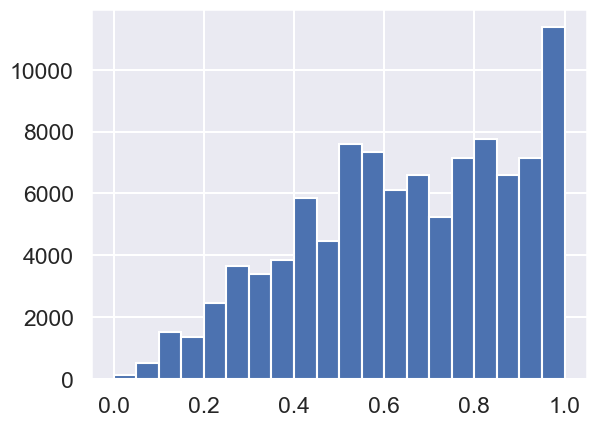

In [22]:
binwidth=0.05
plt.hist(
    XX["unique_ratio"],
    bins=np.arange(0, 1+binwidth, binwidth)
);

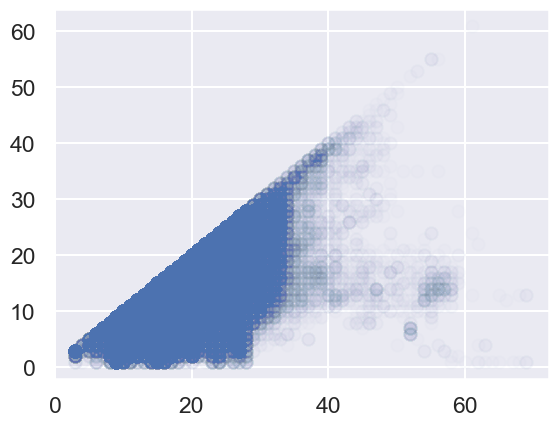

In [23]:
plt.scatter(
    XX["n_stacks"],
    XX["nunique_stacks"],
    alpha=0.01
);

## 2x2 Stacks and items

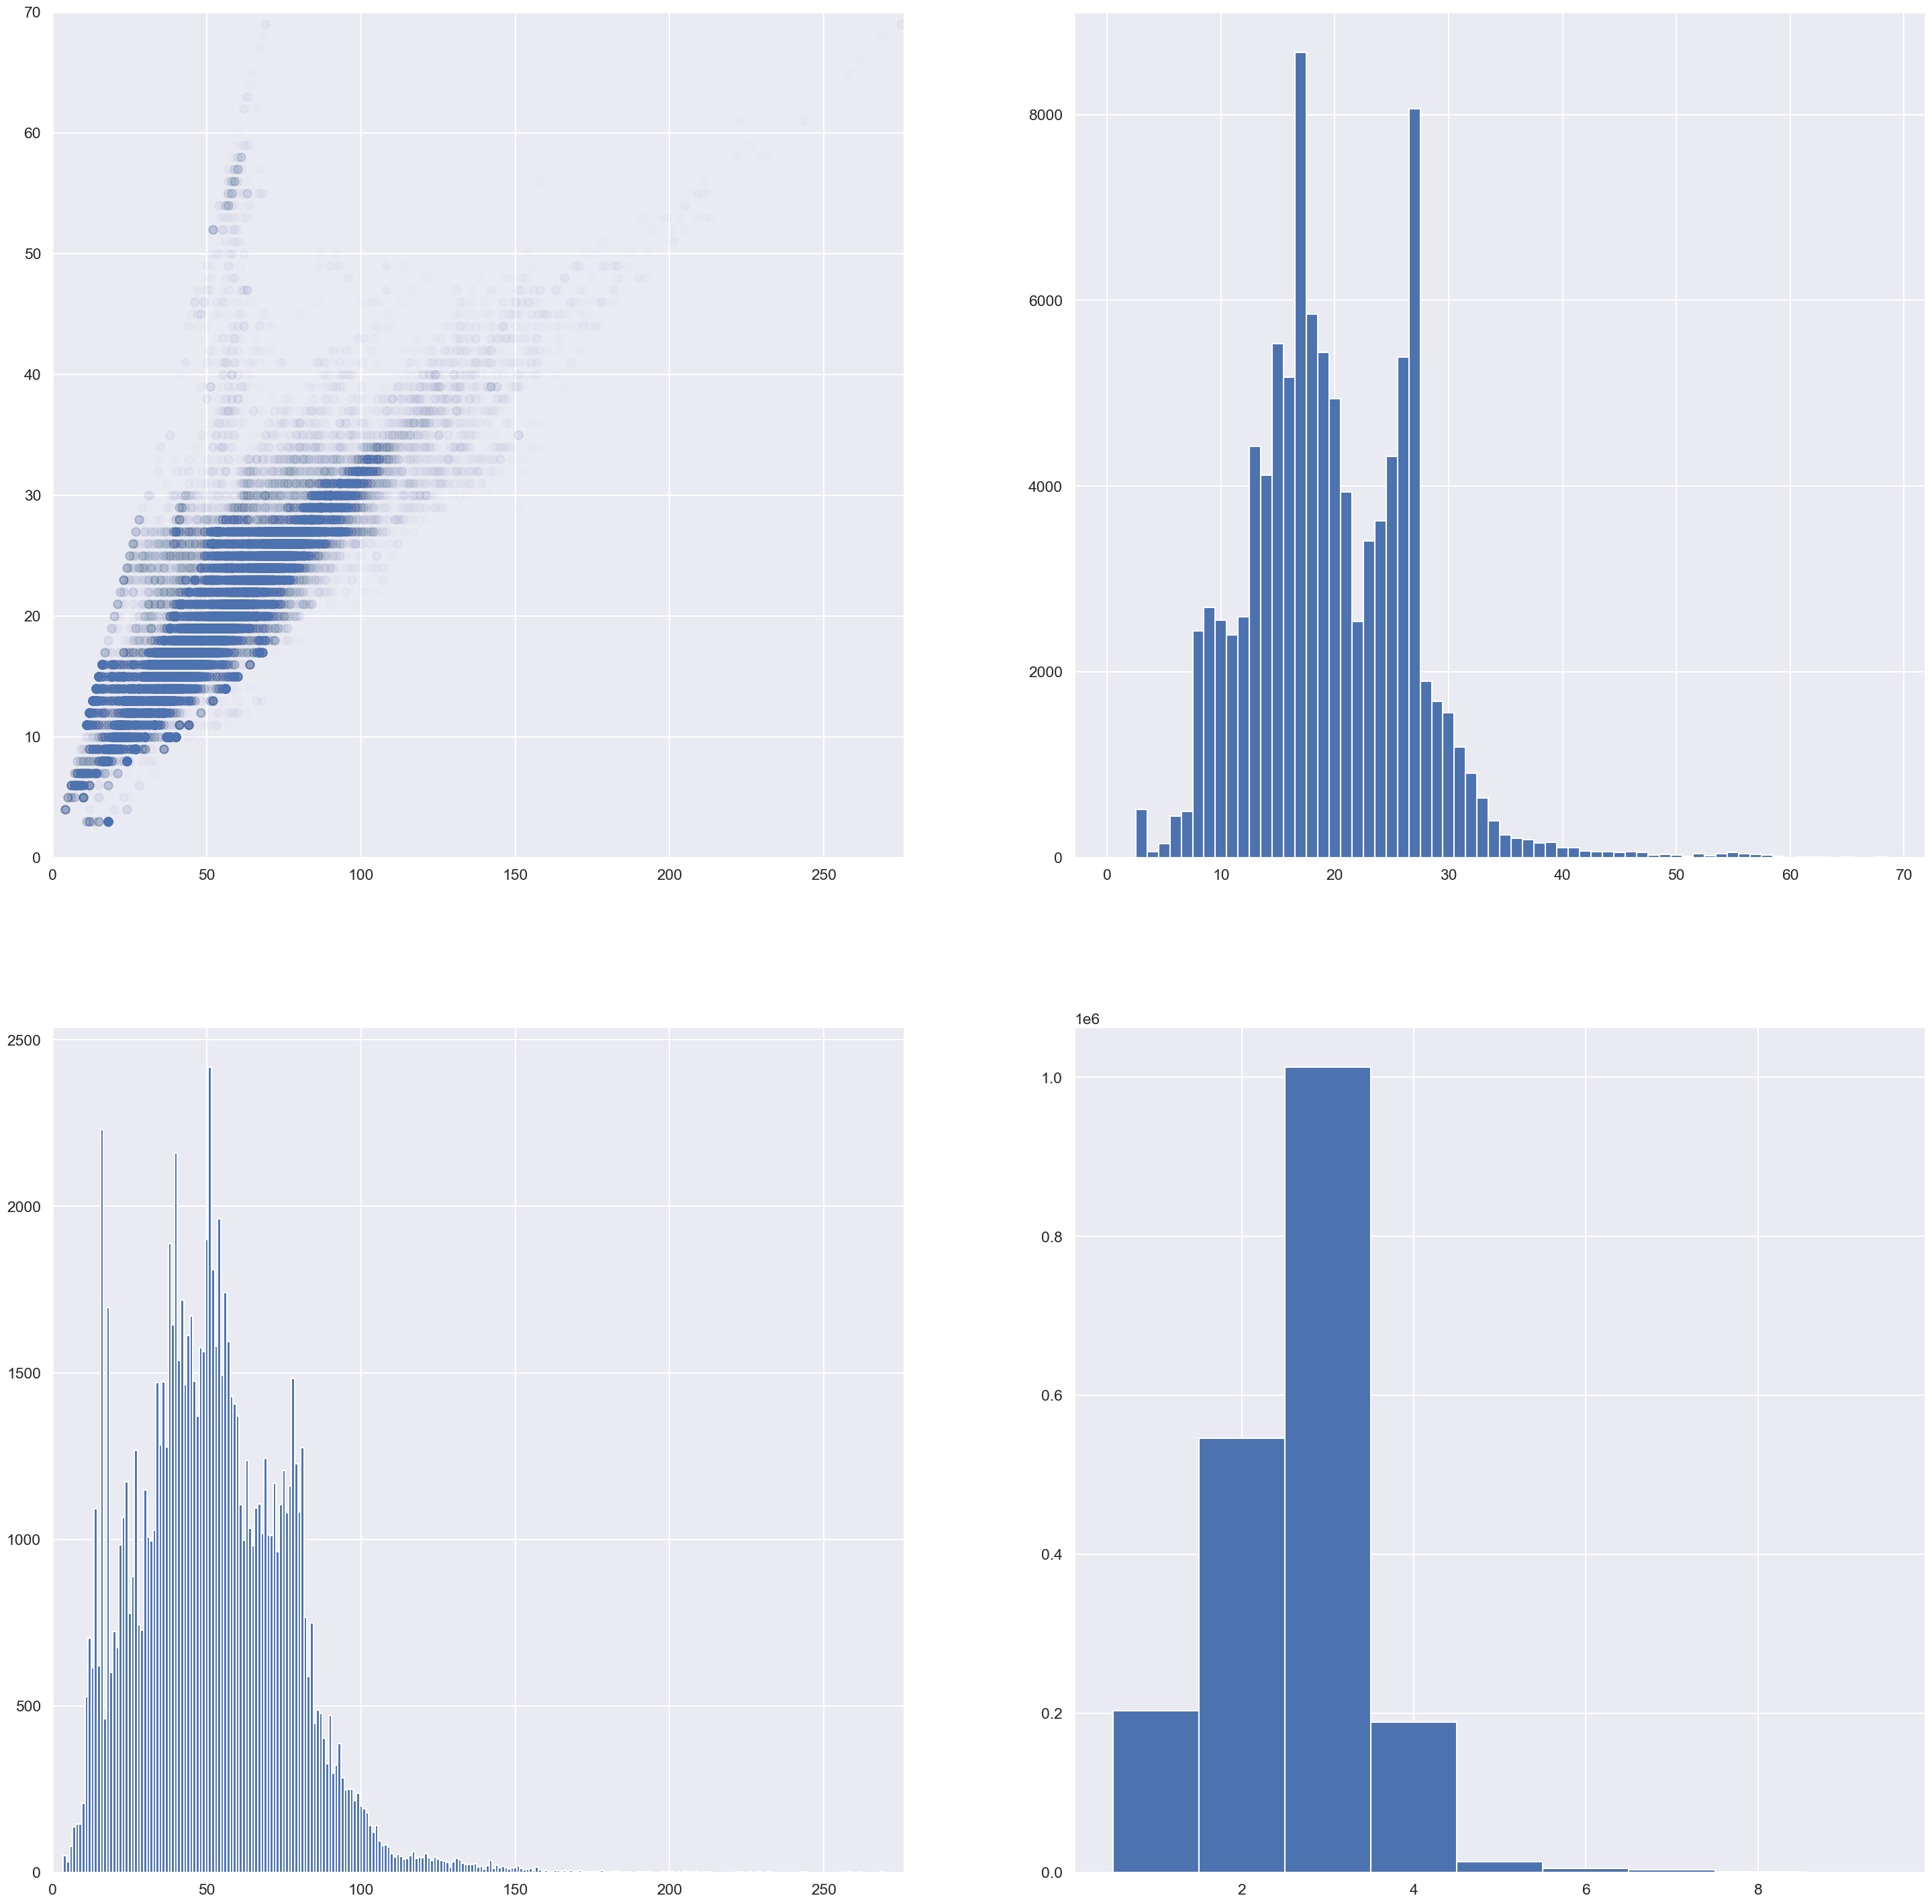

In [24]:
x = X.group_by("index").agg(
    pl.col("items").sum().alias("total_items"),
    pl.col("items").count().alias("total_stacks")
)

item_max = x.max()[0, "total_items"]
stack_max = x.max()[0, "total_stacks"]

fig, ax = plt.subplots(nrows=2, ncols=2,figsize = (36, 36))



ax[0, 0].scatter(
    y=x["total_stacks"],
    x=x["total_items"],
    #c = y.numpy(),
    alpha = 0.01
);
ax[0, 0].set(xlim=[0, item_max+1])
ax[0, 0].set(ylim=[0, stack_max+1])

ax[0, 1].hist(x["total_stacks"], bins=np.arange(0, stack_max, 1)+0.5)

ax[1, 0].hist(x["total_items"], bins=np.arange(0, item_max, 1)+0.5)
ax[1, 0].set(xlim=[0, item_max+1])



x = X["items"].to_numpy()
ax[1, 1].hist(x, bins=np.arange(0, 10, 1)+0.5);


## MIP Improvements:

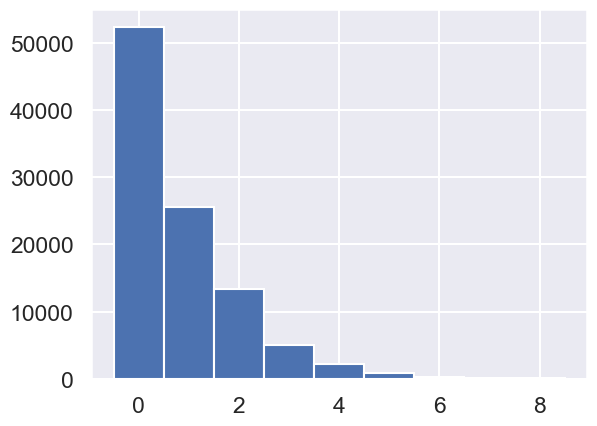

In [25]:
# Number of MIP Improvements:
x = df["raw"].str.extract_all("MIP Improvement (-)").list.len().to_pandas()
x = x-1
x.hist(bins = np.arange(0, 10, 1)-0.5);

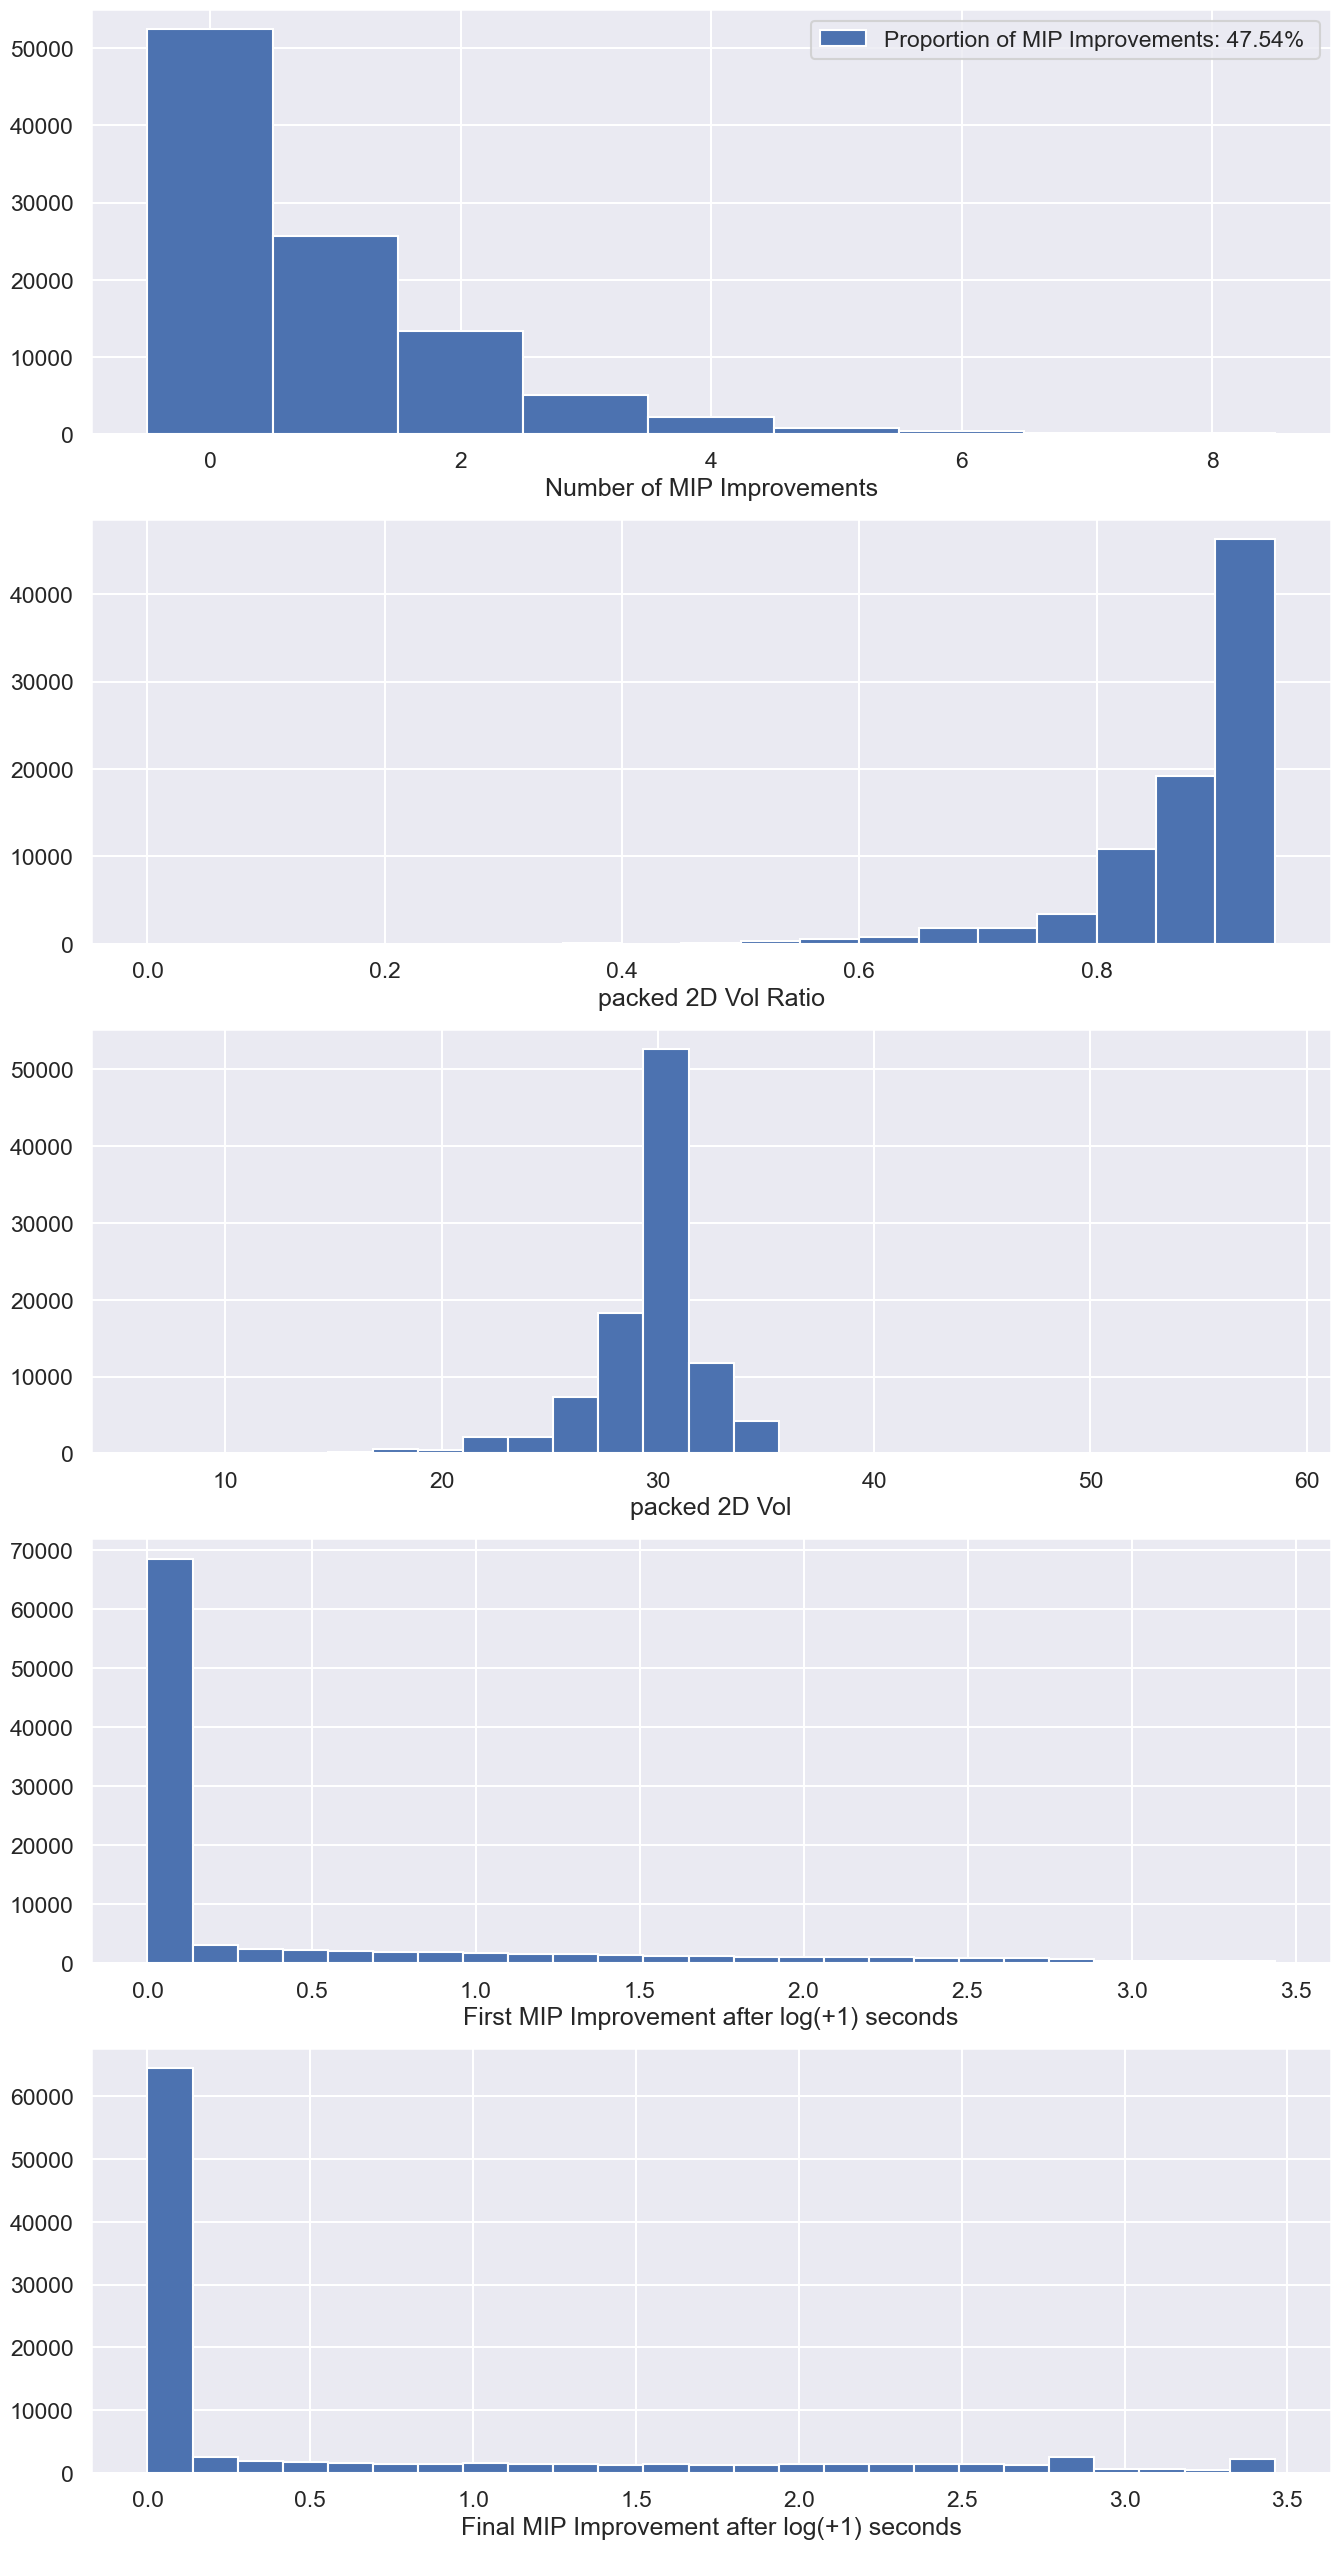

In [26]:
pattern = "MIP Improvement - 2D Vol: \d*\.\d* \[m2\] - packed 2D Vol Ratio\: \d*\.\d* \[\%\] - after \d*\.\d* \[s\]"
mip_improvements = df["raw"].str.extract_all(pattern)#.list[-1][2]

fig, ax = plt.subplots(5, figsize = (16, 32))

y_num_improvements = mip_improvements.list.len()-1
ax[0].hist(y_num_improvements, bins = np.arange(0, 10, 1)-0.5,
           label=f"Proportion of MIP Improvements: {(y_num_improvements>0).mean():.2%} ");
ax[0].set(xlabel="Number of MIP Improvements")

y_packed_area_ratio = mip_improvements.list[-1].str.extract("\: (\d*\.\d*) \[\%\]").cast(pl.Float32)
ax[1].hist(y_packed_area_ratio, bins = np.arange(0, 1, 0.05));
ax[1].set(xlabel="packed 2D Vol Ratio")

#ax[2].hist((y_packed_area_ratio)**10, bins = 25);
#ax[2].set(xlabel="packed 2D Vol Ratio to the power 10")

y_packed_area = mip_improvements.list[-1].str.extract("- 2D Vol: (\d*\.\d*) \[m2\]").cast(pl.Float32)
ax[2].hist(y_packed_area, bins = 25);
ax[2].set(xlabel="packed 2D Vol")





y_first_update = mip_improvements.list[1].str.extract("- after (\d*\.\d*) \[s\]").cast(pl.Float32).fill_null(0)
ax[3].hist(np.log1p(y_first_update), bins = 25);
ax[3].set(xlabel="First MIP Improvement after log(+1) seconds")




y_last_update = mip_improvements.list[-1].str.extract("- after (\d*\.\d*) \[s\]").cast(pl.Float32)
ax[4].hist(np.log1p(y_last_update), bins = 25);
ax[4].set(xlabel="Final MIP Improvement after log(+1) seconds")


ax[0].legend();

#mip_improvements

In [27]:
print(df[1,0])

dataset: C
instance: CL3
+-----------+
2D Packing MIP with Time Limit 30 [s] in Truck P086011101
Stack 0 with items: ['0090016100_28022023003579', '0090016100_28022023003579', '0090016100_28022023003579']
Stack 1 with items: ['0090016100_28022023003548', '0090016100_28022023003548', '0090016100_28022023003579']
Stack 2 with items: ['0090016100_28022023000971', '0090016100_28022023000971', '0090016100_28022023000971']
Stack 3 with items: ['0090016100_28022023004754', '0090016100_28022023002405', '0090016100_28022023002405']
Stack 4 with items: ['0090016100_28022023002405', '0090016100_28022023002405', '0090016100_28022023002405']
Stack 5 with items: ['0090016100_28022023002405', '0090016100_28022023002405', '0090016100_28022023002405']
Stack 6 with items: ['0090016100_28022023002405', '0090016100_28022023002405', '0090016100_28022023002405']
Stack 7 with items: ['0090016100_28022023002405', '0090016100_28022023002405', '0090016100_28022023002405']
Stack 8 with items: ['0090016100_280220

## Missing Stacks

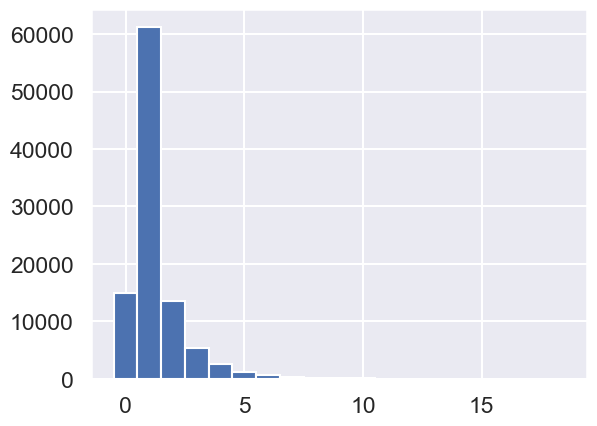

In [28]:
pattern = "Stack (\d*) not in final solution with items:"
#df["raw"].str.extract_all(pattern).apply(lambda x: [i.split(" ")[1] for i in x])
x = df["raw"].str.extract_all(pattern).map_elements(lambda x: [int(i.split(" ")[1]) for i in x])
plt.hist(x.list.len(), bins=np.arange(0, 20, 1)-0.5);
#Number of missing items in final solution:

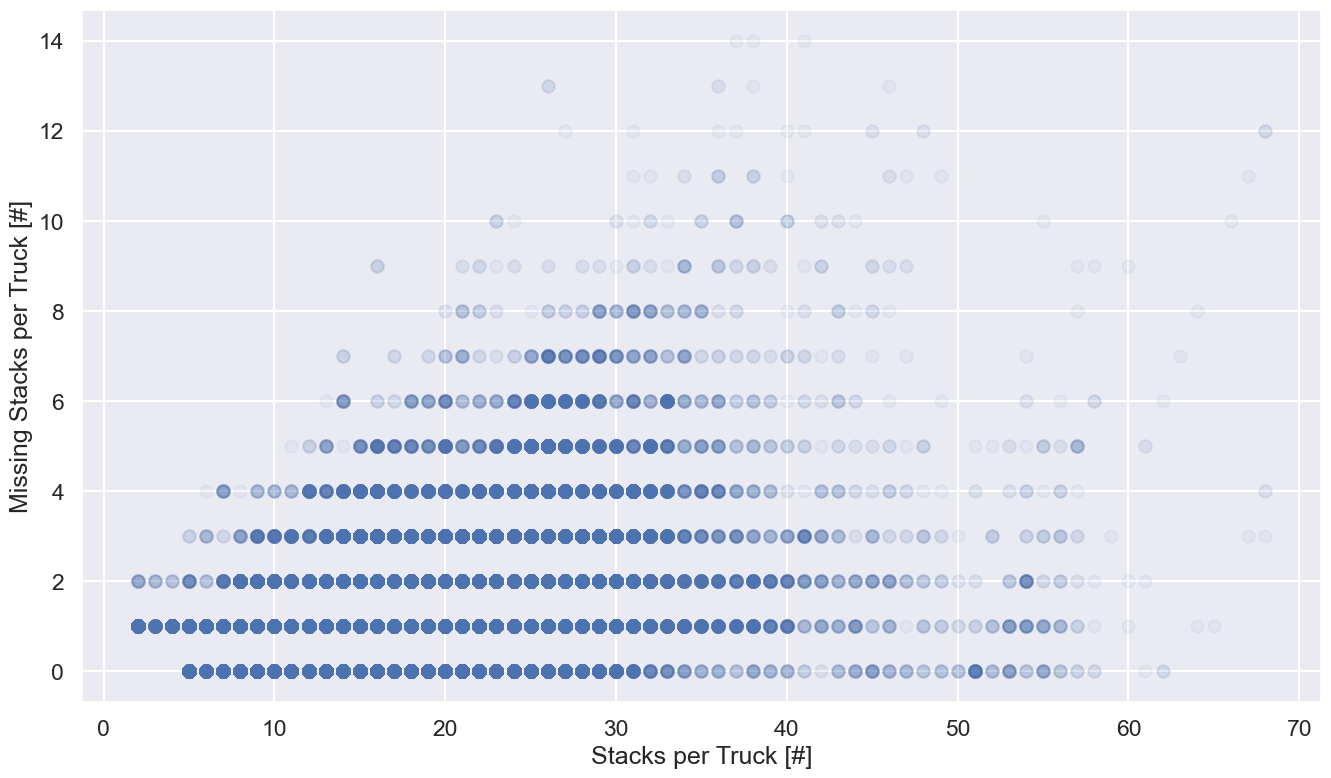

In [29]:
pattern = "Stack (\d*) with items:"
#df["raw"].str.extract_all(pattern).apply(lambda x: [i.split(" ")[1] for i in x])
y = df["raw"].str.extract_all(pattern)#.map_elements(lambda x: [int(i.split(" ")[1]) for i in x])
y = y.map_elements(lambda x: max(int(i.split(" ")[1]) for i in x))

plt.figure(figsize=(16, 9))
plt.scatter(y, x.list.len(), alpha=0.05);
plt.xlabel("Stacks per Truck [#]")
plt.ylabel("Missing Stacks per Truck [#]");

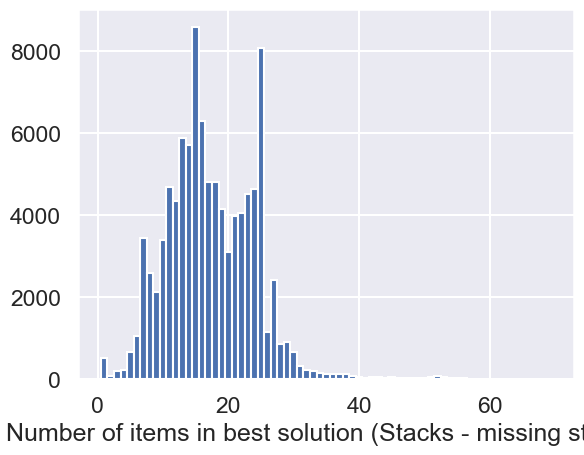

In [30]:
plt.hist(y-x.list.len(), bins=np.arange(0, 70, 1)+0.5);
plt.xlabel("Number of items in best solution (Stacks - missing stacks)");

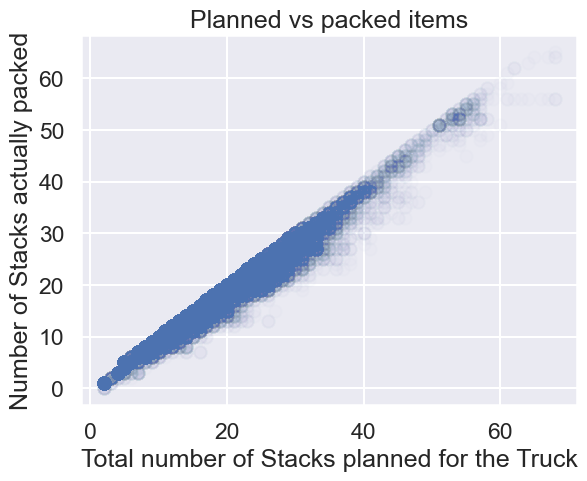

In [31]:
plt.scatter(y, y-x.list.len(), alpha=0.01);
plt.title("Planned vs packed items");
plt.xlabel("Total number of Stacks planned for the Truck")
plt.ylabel("Number of Stacks actually packed");

In [32]:
x = X.group_by("index").agg(
    pl.col("items").sum().alias("total_items"),
    pl.col("items").count().alias("total_stacks")
)

x["total_stacks"].max()

69

In [33]:
import plotly.express as px

# https://stackoverflow.com/questions/52771328/plotly-chart-not-showing-in-jupyter-notebook
import plotly.io as pio
pio.renderers.default = 'iframe'

x = X.group_by("index").agg(
    pl.col("items").sum().alias("total_items"),
    pl.col("items").count().alias("total_stacks")
)

px.scatter(
    x,
    y="total_stacks",
    x="total_items",
    opacity = 0.1
)

## Time Limit Available:

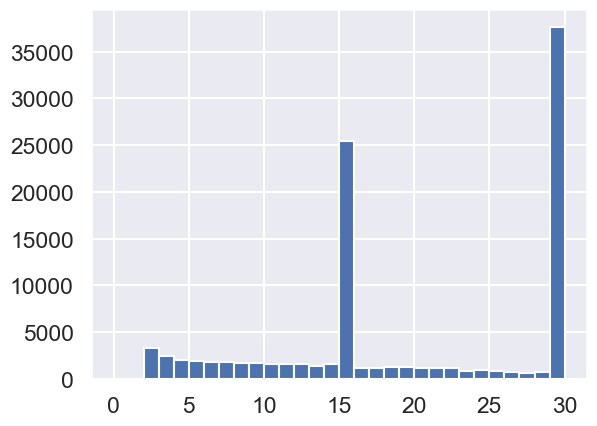

In [34]:
pattern = "2D Packing MIP with Time Limit (\d*\.?\d*) \[s\]"
x = df["raw"].str.extract(pattern).cast(pl.Float32)
plt.hist(x, bins=np.arange(0, 31, 1));

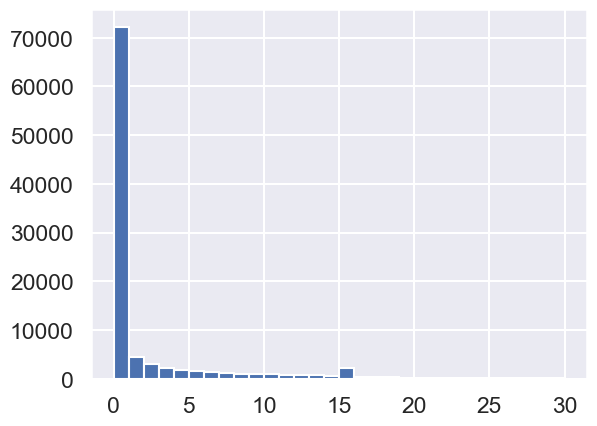

In [35]:
pattern = "- after (\d*\.?\d*) \[s\]"
y = mip_improvements.list[-1].str.extract(pattern).cast(pl.Float32)
plt.hist(y, bins=np.arange(0, 31, 1));

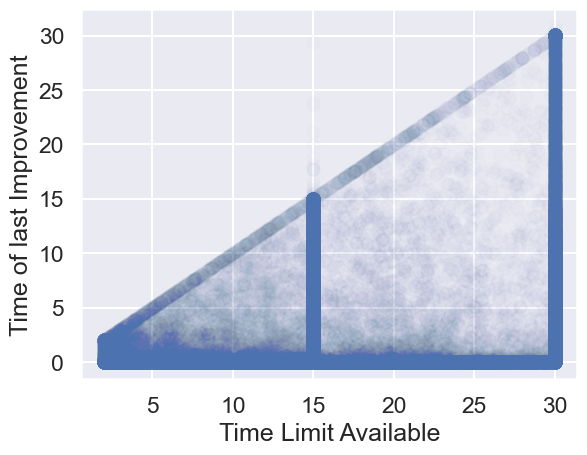

In [36]:
plt.scatter(x, y, alpha = 0.01);
plt.xlabel("Time Limit Available")
plt.ylabel("Time of last Improvement");
#plt.xscale("log")
#plt.yscale("log")

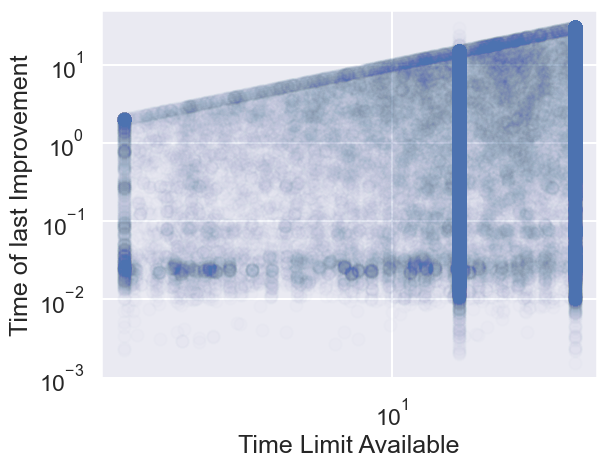

In [37]:
plt.scatter(x, y, alpha = 0.01);
plt.xlabel("Time Limit Available")
plt.ylabel("Time of last Improvement");
plt.xscale("log")
plt.yscale("log")

# Relationship between Improvements and Solved:

In [38]:
y_improvement = (mip_improvements.list.len() > 1)
y_improvement = y_improvement.rename("Improvement")
y_improvement = y_improvement.cast(int)
y_improvement.head(5)

Improvement
i64
0
0
1
1
0


In [39]:
pattern = "Optimal Solution confirmed after"
y_solved = df["raw"].str.contains(pattern)
y_solved = y_solved.rename("Solved")
y_solved = y_solved.cast(int)
y_solved.head(5)

Solved
i64
1
0
0
0
1


In [40]:
tab = pd.crosstab(
    pd.Series(y_solved, name="Solved"),
    pd.Series(y_improvement, name="Improvement"),
    normalize=False
)

tab

Improvement,0,1
Solved,,
0,36855,24160
1,15606,23379


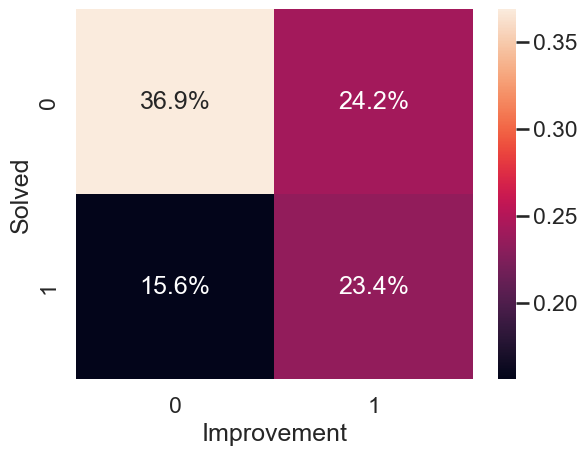

In [41]:
tab = pd.crosstab(
    pd.Series(y_solved, name="Solved"),
    pd.Series(y_improvement, name="Improvement"),
    normalize=True
)

sns.heatmap(tab.iloc[:,:], annot=True, fmt=".1%");

In [42]:
round(tab*100, 1)

Improvement,0,1
Solved,,
0,36.9,24.2
1,15.6,23.4


In [43]:
f"{np.corrcoef(y_solved, y_improvement)[1, 0]:.1%}"

'19.9%'

In [44]:
from scipy.stats import chi2_contingency

tab = pd.crosstab(y_solved, y_improvement, normalize=False)
res = chi2_contingency(tab)
res

Chi2ContingencyResult(statistic=3957.694311230465, pvalue=0.0, dof=1, expected_freq=array([[32009.07915, 29005.92085],
       [20451.92085, 18533.07915]]))

In [47]:
res.pvalue

0.0

In [45]:
expexted_tab = res.expected_freq
(tab - expexted_tab)/len(df)

col_0,0,1
row_0,,
0,0.048459,-0.048459
1,-0.048459,0.048459
